In [1]:
# Part 1: Data Cleaning & Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Load your dataset. The CSV should include 'temperature', 'pressure', 'enthalpy'.
df = pd.read_csv('for_value.csv')

# Display missing values per column and drop rows with missing values.
print("Missing values per column:")
print(df.isnull().sum())
df = df.dropna()



Missing values per column:
Unnamed: 0                          0
P (MPa)                             0
T (°C)                              0
Specific Volume (m^3/kg)            0
Density (kg/m^3)                    3
Specific Internal Energy (kJ/kg)    0
Specific Enthalpy (kJ/kg)           3
Specific Entropy [kJ/(kg K)]        3
dtype: int64


In [3]:
# Function to remove outliers using the IQR method.
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Remove outliers from the features.
for col in ['T (°C)', 'P (MPa)']:
    df = remove_outliers(df, col)



In [4]:
# Define features and target.
X = df[['T (°C)', 'P (MPa)']].values
y = df['Specific Enthalpy (kJ/kg)'].values.reshape(-1, 1)

# Split data into Train, Validation, and Test sets (70%/15%/15%).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the features.
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_valid = scaler_X.transform(X_valid)
X_test = scaler_X.transform(X_test)

# Normalize the target values.
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_valid = scaler_y.transform(y_valid)
y_test = scaler_y.transform(y_test)

print("Data cleaning and normalization complete.")

Data cleaning and normalization complete.


In [5]:
# Define a residual block.
class ResidualBlock(nn.Module):
    def __init__(self, in_features, hidden_features, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_features, in_features)  # output same dimension as input
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        residual = x  # Save input for skip connection
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += residual  # Add skip connection
        out = self.relu(out)
        return out


In [6]:
# Define the ResidualDNN model.
class ResidualDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_blocks, output_size, dropout=0.2):
        super(ResidualDNN, self).__init__()
        # Initial layer: expand input to hidden dimension.
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.bn_input = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        # Stack several residual blocks.
        self.blocks = nn.Sequential(
            *[ResidualBlock(hidden_size, hidden_size * 2, dropout=dropout) for _ in range(num_blocks)]
        )

        # Final output layer.
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.bn_input(x)
        x = self.relu(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x

In [7]:
# Helper function to count parameters.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Set parameters for the model.
input_size = X_train.shape[1]  # For example, 2 features: temperature and pressure.
hidden_size = 128               # Hidden dimension size.
num_blocks = 3                  # Number of residual blocks.
output_size = 1                 # Single output: enthalpy.

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model.
model = ResidualDNN(input_size, hidden_size, num_blocks, output_size, dropout=0.3).to(device)
print("ResidualDNN instantiated with", count_parameters(model), "parameters.")

ResidualDNN instantiated with 200833 parameters.


In [8]:
from tqdm import tqdm

# Convert numpy arrays to PyTorch tensors.
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
X_valid_torch = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_torch = torch.tensor(y_valid, dtype=torch.float32).to(device)

# Create a DataLoader for mini-batch training.
batch_size = 32
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the loss function.
loss_function = nn.MSELoss()

In [9]:
# Define a MAPE metric.
def MAPE(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + 1e-7)))

# Use AdamW optimizer with weight decay for regularization.
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-4)

# Use a ReduceLROnPlateau scheduler to lower the learning rate if validation loss plateaus.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

C:\Users\kadde\anaconda3\envs\MLInterpreter\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# Training parameters.
n_epochs = 250
best_val_loss = float('inf')
patience = 20  # Early stopping patience
trigger_times = 0

for epoch in range(n_epochs):
    model.train()
    train_losses = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # Validation step.
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_valid_torch)
        val_loss = loss_function(val_predictions, y_valid_torch)
        mape_val = MAPE(y_valid_torch, val_predictions).item() * 100

    # Adjust the learning rate based on validation loss.
    scheduler.step(val_loss)

    # Early stopping check.
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss.item():.4f}, Val MAPE = {mape_val:.2f}%")

Epoch 0: Train Loss = 0.3283, Val Loss = 0.0880, Val MAPE = 49.06%
Epoch 10: Train Loss = 0.0980, Val Loss = 0.0544, Val MAPE = 34.19%
Epoch 20: Train Loss = 0.0790, Val Loss = 0.0589, Val MAPE = 37.66%
Epoch 30: Train Loss = 0.0765, Val Loss = 0.0411, Val MAPE = 27.57%
Epoch 40: Train Loss = 0.0683, Val Loss = 0.0483, Val MAPE = 32.76%
Epoch 50: Train Loss = 0.0644, Val Loss = 0.0401, Val MAPE = 28.97%
Early stopping triggered at epoch 59


In [11]:
# Convert test data to PyTorch tensors.
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_torch)
    test_loss = loss_function(test_predictions, y_test_torch)
    test_mape = MAPE(y_test_torch, test_predictions).item() * 100

print(f"Test Loss = {test_loss.item():.4f}, Test MAPE = {test_mape:.2f}%")


Test Loss = 0.0598, Test MAPE = 37.13%


In [12]:
# Get predictions from the model (if not already computed)
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_torch)

# Convert predictions and actual values from tensors to numpy arrays and inverse transform
test_predictions_inv = scaler_y.inverse_transform(test_predictions.cpu().detach().numpy())
y_test_inv = scaler_y.inverse_transform(y_test_torch.cpu().detach().numpy())

# Create a DataFrame with Actual and Predicted values
df_results = pd.DataFrame({
    'Actual': y_test_inv.flatten(),
    'Predicted': test_predictions_inv.flatten()
})

# Display the first few rows of the DataFrame
print(df_results.head())

        Actual    Predicted
0   486.059967   522.754028
1   377.990021   449.642609
2  4494.000000  4360.854492
3  4349.799805  4241.103516
4  4343.500000  4230.824219


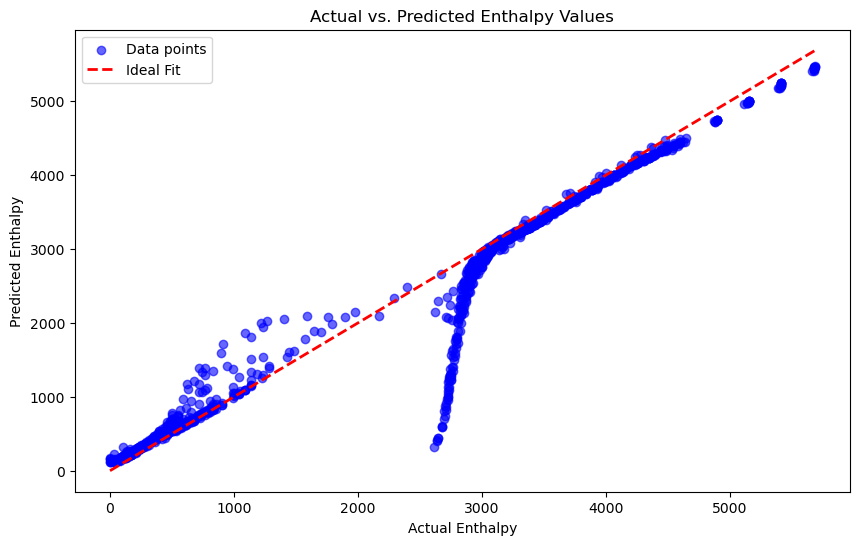

In [13]:
# Plot Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(df_results['Actual'], df_results['Predicted'], alpha=0.6, color='blue', label='Data points')
plt.plot([df_results['Actual'].min(), df_results['Actual'].max()],
         [df_results['Actual'].min(), df_results['Actual'].max()],
         'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Enthalpy')
plt.ylabel('Predicted Enthalpy')
plt.title('Actual vs. Predicted Enthalpy Values')
plt.legend()
plt.show()

In [14]:
df_results

,Actual,Predicted
0,486.059967,522.754028
1,377.990021,449.642609
2,4494.000000,4360.854492
3,4349.799805,4241.103516
4,4343.500000,4230.824219
...,...,...
1126,424.360016,476.663116
1127,3432.400146,3354.918213
1128,85.789932,168.464249
1129,2853.199951,2259.760986


In [15]:
# Option 1: Using input() prompts (works in Colab)
temp_input = float(input("Enter temperature: "))
pressure_input = float(input("Enter pressure: "))

# Create a 2D array for the single sample (ensure it matches the original feature order)
custom_input = np.array([[temp_input, pressure_input]])

# Scale the input using the same scaler used during training
custom_input_scaled = scaler_X.transform(custom_input)

# Convert to a PyTorch tensor and move to the appropriate device
custom_input_tensor = torch.tensor(custom_input_scaled, dtype=torch.float32).to(device)

# Set the model to evaluation mode and predict
model.eval()
with torch.no_grad():
    custom_prediction = model(custom_input_tensor)

# Inverse transform the prediction to get it back to the original scale
custom_prediction_inv = scaler_y.inverse_transform(custom_prediction.cpu().detach().numpy())

print(f"Predicted enthalpy: {custom_prediction_inv[0,0]:.4f}")


Predicted enthalpy: 1515.2687


In [16]:
# Save the model's state_dict to a file named "model.pth"
torch.save(model.state_dict(), "model.pth")
print("Model saved successfully!")

Model saved successfully!


In [17]:
# Make sure to use the same parameters as during training.
model_loaded = ResidualDNN(input_size, hidden_size, num_blocks, output_size, dropout=0.3).to(device)

# Load the saved state dictionary.
model_loaded.load_state_dict(torch.load("model.pth"))

# Set the model to evaluation mode.
model_loaded.eval()

print("Model loaded successfully!")

Model loaded successfully!


C:\Users\kadde\AppData\Local\Temp\ipykernel_28652\1272307537.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load("model.pth"))


In [19]:
# Option 1: Using input() prompts (works in Colab)
temp_input = float(input("Enter temperature: "))
pressure_input = float(input("Enter pressure: "))

# Create a 2D array for the single sample (ensure it matches the original feature order)
custom_input = np.array([[temp_input, pressure_input]])

# Scale the input using the same scaler used during training
custom_input_scaled = scaler_X.transform(custom_input)

# Convert to a PyTorch tensor and move to the appropriate device
custom_input_tensor = torch.tensor(custom_input_scaled, dtype=torch.float32).to(device)

# Set the model to evaluation mode and predict
model.eval()
with torch.no_grad():
    custom_prediction = model(custom_input_tensor)

# Inverse transform the prediction to get it back to the original scale
custom_prediction_inv = scaler_y.inverse_transform(custom_prediction.cpu().detach().numpy())

print(f"Predicted enthalpy: {custom_prediction_inv[0,0]:.4f}")

Predicted enthalpy: 568.8916
